# Active Learning on the TwoMoons dataset

The aim of this notebook is to explore how active learning works. By working with a small 2D toy dataset, it is easy to visualize predictions of the model.

#### Outline:
- Visualize dataset
- Fit a Gaussian Process to the data and plot the resulting decision boundary.
- Implement an active learning framework and use it with a Gaussian Process.
- Implement different acquisition functions and visualize the resulting sampling behavior and decision boundary.


In [23]:
import os
os.chdir('/Users/madsbirch/Documents/bal')
print("Current working directory: {0}".format(os.getcwd()))

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
%autoreload 2

Current working directory: /Users/madsbirch/Documents/bal
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import time 
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

import pickle

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset


from src.models.model import AL_Model, TwoMoons_Model, PaperCNN
from src.data.data import get_dataloaders, TwoMoons
from src.models.train_model import train, test
from src.features.utils import softmax_grid, accuracy, predict
from src.features.sampling import Sampling


from netcal.metrics import ECE
from torchmetrics import CalibrationError
from torchmetrics.classification import BinaryCalibrationError

torch.manual_seed(0)
np.random.seed(1)
random.seed(0)

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cpu'
print(f"Using device: {device}")

FIGURE_PATH = '/Users/madsbirch/Documents/4_semester/BAL/bayesian-active-learning/reports/figures/'

#plt.style.use('ggplot')

Using device: cpu


## Exploratory Data Analysis & Basic Modelling

In [25]:
# generate data
X, y = make_moons(n_samples = 1000, noise = 0.15, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

traindata = TwoMoons(X_train, y_train, return_idx = True)
testdata = TwoMoons(X_test, y_test, return_idx = True)

# dataloader and dataset class
train_loader, test_loader = get_dataloaders(traindata, testdata, batch_size=128)

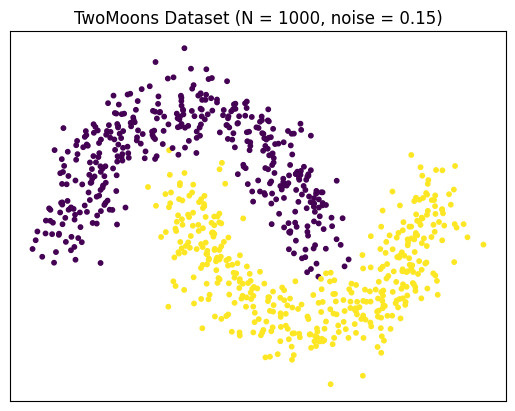

In [28]:

plt.scatter(X_train[:,0], X_train[:,1], c = y_train, s = 10)
plt.xticks([])
plt.yticks([])
plt.title("TwoMoons Dataset (N = 1000, noise = 0.15)")
plt.show()

### Gaussian Process

Fitting an out of the box Gaussian Process from Sklearn to the entire dataset results as expected in a high accuracy and a good decision boundary.

Accuracy on test set: 95.5%


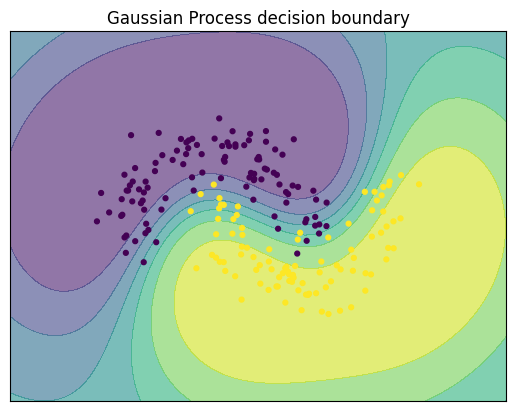

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier

gpc = GaussianProcessClassifier(random_state=0).fit(X_train, y_train)
preds = gpc.predict(X_test)
acc_gp =  accuracy(preds, y_test)

print(f'Accuracy on test set: {acc_gp:.1%}')

DecisionBoundaryDisplay.from_estimator(gpc, X_test, alpha = 0.6)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test, s = 12)
plt.xticks([])
plt.yticks([])
plt.title("Gaussian Process decision boundary")
plt.show()

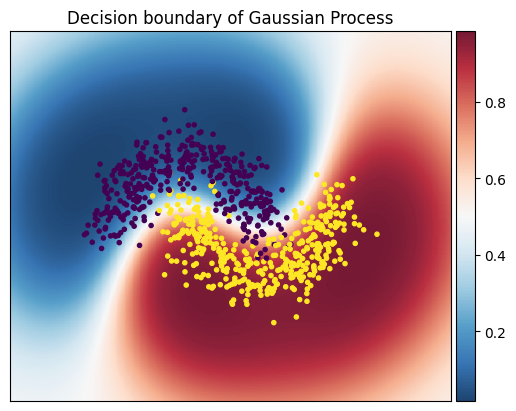

In [8]:
### calculting the grid
xlim_neg = X_train[:,0].min()-1
xlim_pos = X_train[:,0].max()+1
ylim_neg = X_train[:,1].min()-1
ylim_pos = X_train[:,1].max()+1

x1 = np.linspace(xlim_neg, xlim_pos, 500)
x2 = np.linspace(ylim_neg, ylim_pos, 500)
        
xx, yy = np.meshgrid(x1, x2)
x_grid = np.column_stack((xx.ravel(), yy.ravel()))

gpc_probs = gpc.predict_proba(x_grid)[:,1].reshape(xx.shape)

### plotting decision boundary
mesh_gp = plt.pcolormesh(xx, yy, gpc_probs, cmap=plt.cm.RdBu_r, alpha = 0.9)

plt.colorbar(mesh_gp, fraction=0.1, pad=0.01)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, marker = '.') # to set markers to digits for each query step, put in a for loop and use the index in the marker definition.
plt.xlim(xlim_neg, xlim_pos,)
plt.ylim(ylim_neg, ylim_pos)
plt.xticks([])
plt.yticks([])
plt.title("Decision boundary of Gaussian Process")
plt.show()

### Neural Network

We can also fit a small Neural Network to the data. Below we find that the NN achieves a higher test accuracy than the Gaussian Process. However, when investigating the decision boundary we see that NN is overly confident as it has very high uncertainty in areas away from the data (the upper left and lower right corners). In comparison, the Gaussian process assigns higher uncertainty to these areas as desired.

Accuracy on the test set: 98.5% %


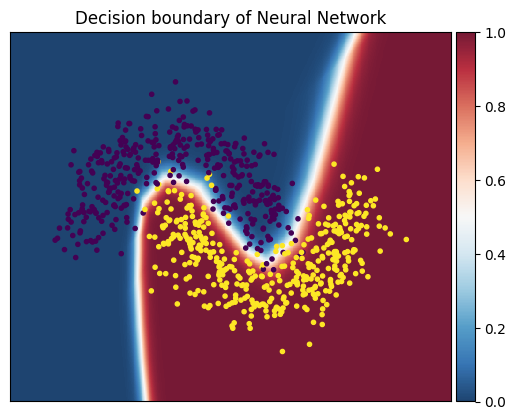

In [12]:
dropout = 0

#model = MLP(dropout=dropout)
model = TwoMoons_Model(dropout=dropout)

optimizer = optim.Adam(model.parameters(), lr = 1e-3)
train(model, train_loader, optimizer, device, valloader = test_loader, val = True, printout = False, plot = False)

acc_nn = test(model, test_loader, device, display = True)

xx, yy, softmax_out_nn = softmax_grid(model, X_train, y_train)
mesh_nn = plt.pcolormesh(xx, yy, softmax_out_nn, cmap=plt.cm.RdBu_r, alpha = 0.9)

plt.colorbar(mesh_nn, fraction=0.1, pad=0.01)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, marker = '.')
# plt.xlim(xlim_neg, xlim_pos,)
# plt.ylim(ylim_neg, ylim_pos)
plt.xticks([])
plt.yticks([])
plt.title("Decision boundary of Neural Network")
plt.show()

### Performance Comparison & Expected Calibration Error

We can compare the decision boundaries of the two models:

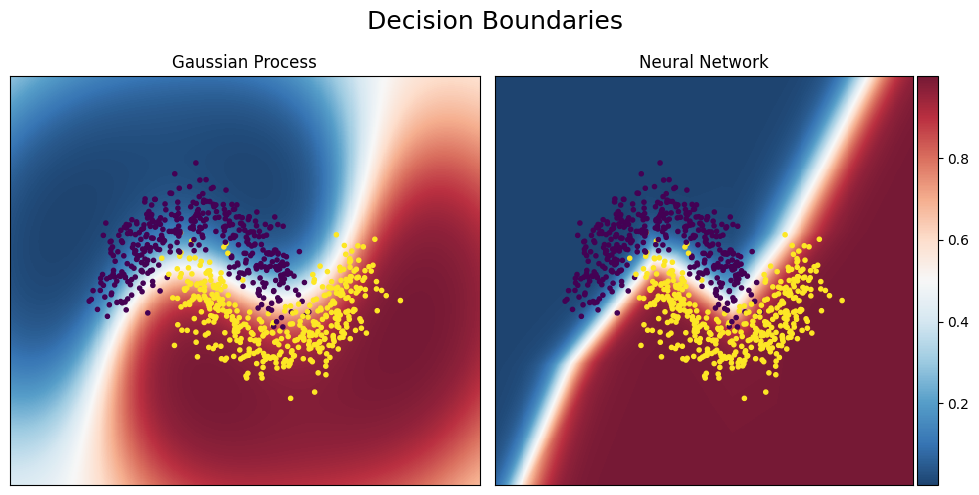

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

mesh_nn = ax2.pcolormesh(xx, yy, softmax_out_nn, cmap=plt.cm.RdBu_r, alpha = 0.9)
ax2.scatter(X_train[:,0], X_train[:,1], c = y_train, marker = '.')
ax2.set_xlim(xlim_neg, xlim_pos,)
ax2.set_ylim(ylim_neg, ylim_pos)
ax2.set_title("Neural Network")
ax2.set_xticks([])
ax2.set_yticks([])
plt.colorbar(mesh_nn, fraction=0.1, pad=0.01)

mesh_gp = ax1.pcolormesh(xx, yy, gpc_probs, cmap=plt.cm.RdBu_r, alpha = 0.9)
ax1.scatter(X_train[:,0], X_train[:,1], c = y_train, marker = '.') # to set markers to digits for each query step, put in a for loop and use the index in the marker definition.
ax1.set_xlim(xlim_neg, xlim_pos,)
ax1.set_ylim(ylim_neg, ylim_pos)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Gaussian Process")

fig.suptitle('Decision Boundaries', size = 18)
fig.tight_layout()
plt.show()

Looking at the Expected Calibration Error (ECE) of the two models, we find that both models are well calibrated.

Why is the NN well calibrated when it is overly confident when looking at the decision boundaries.

In [ ]:
probs_nn = predict(test_loader, model)
probs_gp = torch.tensor(gpc.predict_proba(X_test))

probsmax_nn, _ = torch.max(probs_nn, dim = 1)
probsmax_gp, _ = torch.max(probs_gp, dim = 1)

bce_metric = BinaryCalibrationError(n_bins = 5)
bce_nn = bce_metric(probsmax_nn, torch.tensor(y_test))
bce_gp = bce_metric(probsmax_gp, torch.tensor(y_test))

print(f'[GP] Acc.: {acc_gp:.1%}; ECE: {bce_gp:.1%}')
print(f'[NN] Acc.: {acc_nn:.1%}; ECE: {bce_nn:.1%}')

[GP] Acc.: 95.5%; ECE: 40.0%
[NN] Acc.: 95.5%; ECE: 43.9%


Scikit learn calibration curve


## Active Learning Implementation

AL Framework Outline:

1. Train the model on the initial data pool.
2. Score all data points based on an acquisition function.
3. Query a batch of samples which maximises the information gain wrt. the model parameters.
4. Retrain the model on the new data pool now incluing the newly added query points.
5. Test model performance & investigate decision boundary.
6. Repeat from step 2.



PowerBALD?: https://baal.readthedocs.io/en/latest/user_guide/heuristics/



### Basic Implementation w. Random Sampling

Getting an initial balanced data pool:

In [ ]:
init_pool_size = 10
init_pool_idx = np.random.randint(0,500, size = init_pool_size).tolist()

# model params
batch_size = 256
num_epochs = 50
dropout = 0.3

# active learning params
num_queries = 100
query_size = 1
lr = 1e-4
n_iter = 3
T = 5
MC_iter = 30
n_ens = 3

strat_list = ['random', 'margin', 'entropy', 'bald_mc', 'bald_ens'] # list of sampling strategies


ITER:  1
ITER:  2
ITER:  3


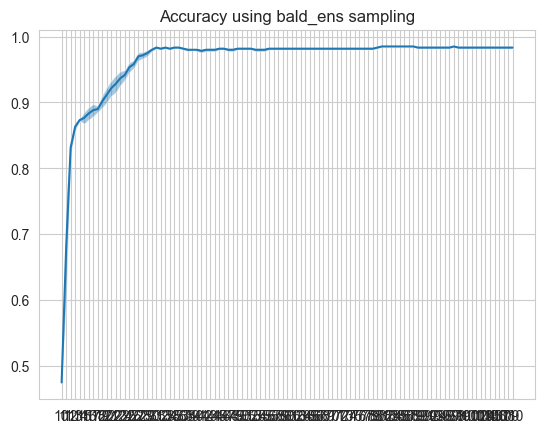

In [ ]:

TEST_ACC = np.zeros((n_iter, num_queries+1))

print_acc = False
plot = True

sampling_strat = 'bald_ens'

for i in range(n_iter):
    print(f'ITER: {i+1:2d}')
    torch.manual_seed(i)
    # reset dataset, model and optimizer
    traindata.reset_mask()
    model = NN(dropout=dropout)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    # train on initial pool
    traindata.update_mask(init_pool_idx)
    labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                    sampler=SubsetRandomSampler(init_pool_idx), shuffle = False)

    model = train(model, labeled_loader, optimizer, device, num_epochs=100, plot = False, printout = False)
    TEST_ACC[i,0] = test(model, test_loader, device, display = False)

    for query in range(num_queries):
        # quering data points
        """
        if sampling_strat == 'bald':
            sample_idx, scores, all_scores, Xs = query_the_oracle(model, traindata, device, query_strategy=sampling_strat, query_size=query_size, T = T, batch_size=batch_size)
        else:
            query_batch = query_the_oracle(device, model, traindata, T = T, query_size=query_size, query_strategy=sampling_strat, bald_method='MC_drop')
        """
        if sampling_strat == 'random':
            query_batch = sampling(traindata, model, query_size, device).random_sampling()
        
        elif sampling_strat == 'margin':
            query_batch = sampling(traindata, model, query_size, device).margin_sampling()
            
        elif sampling_strat == 'entropy':
            query_batch = sampling(traindata, model, query_size, device).entropy_sampling()
        
        elif sampling_strat == 'bald_mc':
            query_batch = sampling(traindata, model, query_size, device).bald_mc_sampling(T = MC_iter)
            
        elif sampling_strat == 'bald_ens':
            query_batch = sampling(traindata, model, query_size, device).bald_ensemble_sampling(T = n_ens, lr = lr)
            
        traindata.update_mask(query_batch.indices)
        labeled_idx = np.where(traindata.unlabeled_mask == 0)[0]
        labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                    sampler=SubsetRandomSampler(labeled_idx), shuffle=False)

        # train model
        model = train(model,labeled_loader,optimizer, device, num_epochs=num_epochs, plot = False, printout = False)

        # test model
        test_acc = test(model, test_loader, device, display = False)
        TEST_ACC[i,query+1] = test_acc
        
        std = TEST_ACC.std(0)/np.sqrt(n_iter)
        mean  = TEST_ACC.mean(0)

        if print_acc:
            print(f'# Samples: {init_pool_size + query*query_size:3d} | Test accururacy : {test_acc:.2f}%')

if plot:
    with sns.axes_style("whitegrid"):
        x = np.linspace(start = init_pool_size,
                    stop = init_pool_size+num_queries*query_size, 
                    num = num_queries+1, 
                    dtype=int)
        
        plt.plot(x, mean)
        plt.title(f'Accuracy using {sampling_strat} sampling')
        plt.fill_between(x, mean+std, mean-std, alpha = 0.4)
        plt.xticks(x)
        plt.show()

### Margin, Entropy and BALD Acquisition Functions

STRATEGY: random
ITER:  1
ITER:  2
ITER:  3
STRATEGY: margin
ITER:  1
ITER:  2
ITER:  3
STRATEGY: entropy
ITER:  1
ITER:  2
ITER:  3
STRATEGY: bald_mc
ITER:  1
ITER:  2
ITER:  3
STRATEGY: bald_ens
ITER:  1
ITER:  2
ITER:  3


/var/folders/dd/s080ztxj4q50zd2xnnx6t0t40000gn/T/ipykernel_7932/3384088729.py:130: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


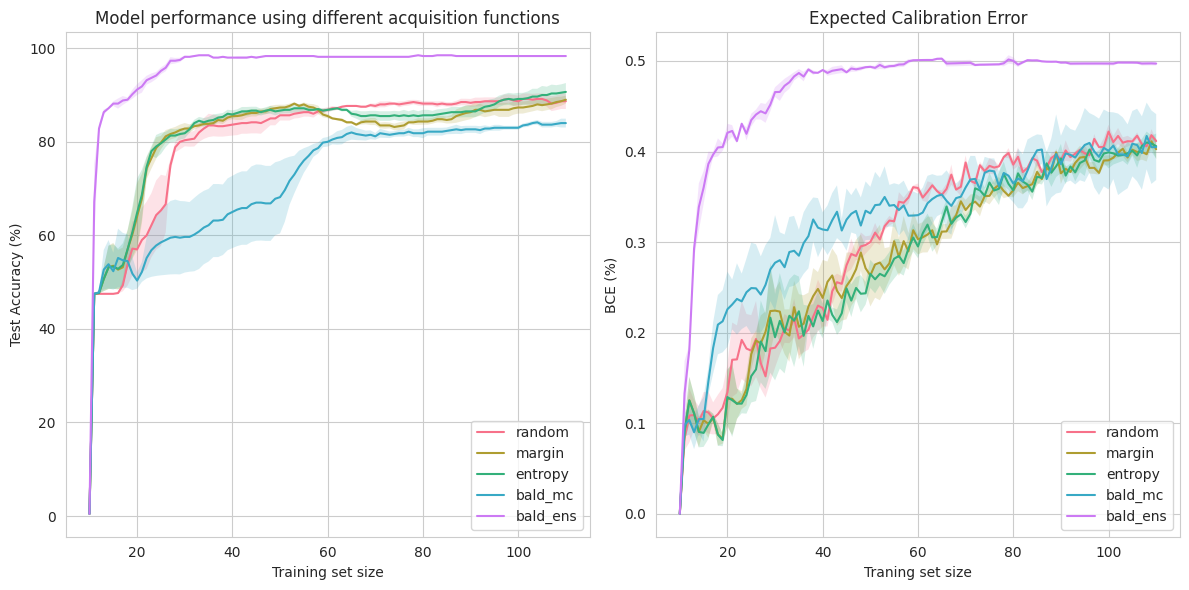

In [ ]:
# active learning params
strat_list = ['random', 'margin', 'entropy', 'bald_mc', 'bald_ens'] # list of sampling strategies

# setup
save_dict = False
plot = True

# lists and dictionaries for storage of performance metrics
bce_metric = BinaryCalibrationError(n_bins = 15)
TEST_ACC = np.zeros((n_iter, num_queries+1))
BCE_list = np.zeros((n_iter, num_queries+1))
query_dict = {
    'bald_mc': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': []},
    'bald_ens': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': []},
    'random': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': []},
    'entropy': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': []},
    'margin': {'acc_mean': [], 'acc_se': [], 'bce_mean': [], 'bce_se': []}
}


# seed list
for s in strat_list:
    #torch.manual_seed(r)
    
    print(f'STRATEGY: {s}')
    for i in range(n_iter):
        print(f'ITER: {i+1:2d}')
        
        torch.manual_seed(i)
        
        # reset dataset model and optimizer
        traindata.reset_mask()
        model = NN(dropout=dropout)# choose a model
        optimizer = optim.Adam(model.parameters(), lr = lr)
        
        # train on initial pool
        traindata.update_mask(init_pool_idx)
        labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                        sampler=SubsetRandomSampler(init_pool_idx), shuffle = False)
    
        model = train(model, labeled_loader, optimizer, device, num_epochs=num_epochs, plot = False, printout = False)
        TEST_ACC[i,0] = test(model, test_loader, device, display = False)
    
        for query in range(num_queries):
            
            # quering data points            
            if s == 'random':
                query_batch = sampling(traindata, model, query_size, device).random_sampling()
            
            elif s == 'margin':
                query_batch = sampling(traindata, model, query_size, device).margin_sampling()
                
            elif s == 'entropy':
                query_batch = sampling(traindata, model, query_size, device).entropy_sampling()
            
            elif s == 'bald_mc':
                query_batch = sampling(traindata, model, query_size, device).bald_mc_sampling(T = MC_iter)
            
            elif s == 'bald_ens':
                query_batch = sampling(traindata, model, query_size, device).bald_ensemble_sampling(T = n_ens, lr = lr)
            
            
            traindata.update_mask(query_batch.indices)
            labeled_idx = np.where(traindata.unlabeled_mask == 0)[0]
            labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                        sampler=SubsetRandomSampler(labeled_idx), shuffle=False)

            # train model
            model = train(model,labeled_loader,optimizer, device, num_epochs=num_epochs, plot = False, printout = False)

            # test model
            probs_nn = predict(test_loader, model)
            probsmax_nn, _ = torch.max(probs_nn, dim = 1)

            bce_nn = bce_metric(probsmax_nn, torch.tensor(y_test))
            
            test_acc = test(model, test_loader, device, display = False)
            TEST_ACC[i,query+1] = test_acc*100
            BCE_list[i,query+1] = bce_nn

            #print(f'# Samples: {init_pool_size + query*query_size:3d} | Accuracy : {test_acc:.2f}%')

    query_dict[s]['acc_se'] = TEST_ACC.std(0)/np.sqrt(n_iter)
    query_dict[s]['acc_mean']  = TEST_ACC.mean(0)
    query_dict[s]['bce_mean']  = BCE_list.mean(0)
    query_dict[s]['bce_se'] = BCE_list.std(0)/np.sqrt(n_iter)
    
    
if save_dict:
    with open("QUERY_DICT_50", "wb") as fp:
        pickle.dump(query_dict, fp)

if plot:
    with sns.axes_style("whitegrid"):

        x_tick_rot = 90
        #x = np.arange(init_pool_size,num_queries+init_pool_size+1,dtype=int)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharex=True)

        
        x = np.linspace(start = init_pool_size,
                        stop = init_pool_size+num_queries*query_size, 
                        num = num_queries+1, 
                        dtype=int)
        clrs = sns.color_palette("husl", len(strat_list))
        for i, s in enumerate(strat_list):
            acc_mean = query_dict[s]['acc_mean']
            acc_std = query_dict[s]['acc_se']
            ax1.plot(x, acc_mean, label = s, c=clrs[i])
            ax1.fill_between(x, acc_mean+acc_std, acc_mean-acc_std, alpha = 0.2, facecolor=clrs[i])
            ax1.legend()
            ax1.set_title('Model performance using different acquisition functions')
            ax1.set_xlabel('Training set size')
            ax1.set_ylabel('Test Accuracy (%)')
            #ax1.tick_params('x', labelrotation=x_tick_rot)

            bce_mean = query_dict[s]['bce_mean']
            bce_std = query_dict[s]['bce_se']
            ax2.plot(x, bce_mean, label = s, c=clrs[i])
            ax2.fill_between(x, bce_mean+bce_std, bce_mean-bce_std, alpha = 0.2, facecolor=clrs[i])

            ax2.legend()
            ax2.set_title('Expected Calibration Error')
            ax2.set_xlabel('Traning set size')
            ax2.set_ylabel('BCE (%)')
            #ax2.tick_params('x', labelrotation=x_tick_rot)

    fig.savefig('reports/figures/TwoMoons_results_1.png')
    fig.tight_layout()
    fig.show()

### Performance evaluation

### Sampling behavior of different acquisition functions

In this section we will investigate the resulting decision boundaries for each of the acquisition functions.

In [ ]:
def plot_decision_boundary_nn(init_pool_idx, acquisition_function = 'entropy',untrained_model = NN(dropout=0), batch_size = 256, num_epochs = 30, num_queries = 100, query_size = 2, lr = 6e-4, n_iter = 3):
    
    # reset dataset model and optimizer
    traindata.reset_mask()
    model = untrained_model
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    # train on initial pool
    traindata.update_mask(init_pool_idx)
    labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                    sampler=SubsetRandomSampler(init_pool_idx), shuffle = False)

    model = train(model, labeled_loader, optimizer, device, num_epochs=num_epochs, plot = False, printout = False)
    TEST_ACC[i,0] = test(model, test_loader, device, display = False)

    for query in range(num_queries):
        
        # quering data points            
        if s == 'random':
            query_batch = sampling(traindata, model, query_size, device).random_sampling()
        
        elif s == 'margin':
            query_batch = sampling(traindata, model, query_size, device).margin_sampling()
            
        elif s == 'entropy':
            query_batch = sampling(traindata, model, query_size, device).entropy_sampling()
        
        elif s == 'bald_mc':
            query_batch = sampling(traindata, model, query_size, device).bald_mc_sampling(T = MC_iter)
        
        elif s == 'bald_ens':
            query_batch = sampling(traindata, model, query_size, device).bald_ensemble_sampling(T = n_ens, lr = lr)
        
        traindata.update_mask(query_batch.indices)
        labeled_idx = np.where(traindata.unlabeled_mask == 0)[0]
        labeled_loader = DataLoader(traindata, batch_size=batch_size, num_workers=0,
                                    sampler=SubsetRandomSampler(labeled_idx), shuffle=False)

        # train model
        model = train(model,labeled_loader,optimizer, device, num_epochs=num_epochs, plot = False, printout = False)

    acc_nn = test(model, test_loader, device, display = True)
    xx, yy, softmax_out_nn = softmax_grid(model, X_train, y_train)
    
    plt.figure(figsize=(6,6))
    mesh_nn = plt.pcolormesh(xx, yy, softmax_out_nn, cmap=plt.cm.RdBu_r, alpha = 0.9)
    plt.colorbar(mesh_nn, fraction=0.1, pad=0.01)
    plt.scatter(X_train[:,0], X_train[:,1], c = y_train, marker = f'${1}$')
    plt.xlim(xlim_neg, xlim_pos,)
    plt.ylim(ylim_neg, ylim_pos)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Decision boundary of Neural Network using {acquisition_function} sampling')
    plt.tight_layout()
    plt.show()

In [ ]:
strat_list

['random', 'margin', 'entropy', 'bald_mc', 'bald_ens']

Accuracy on the test set: 96.0% %


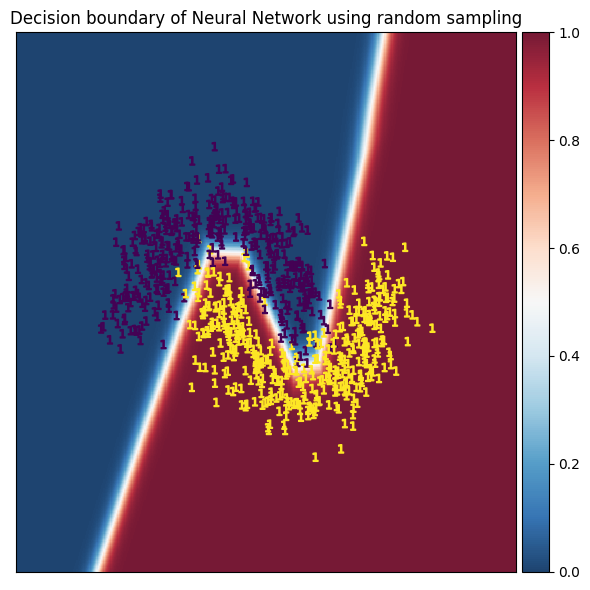

Accuracy on the test set: 98.0% %


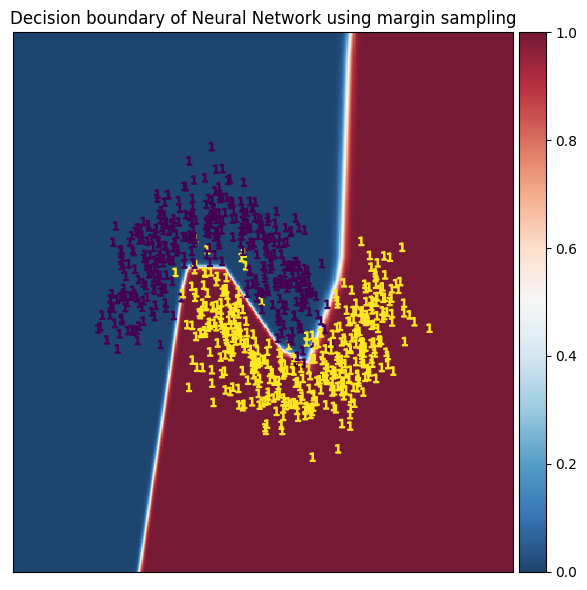

Accuracy on the test set: 97.5% %


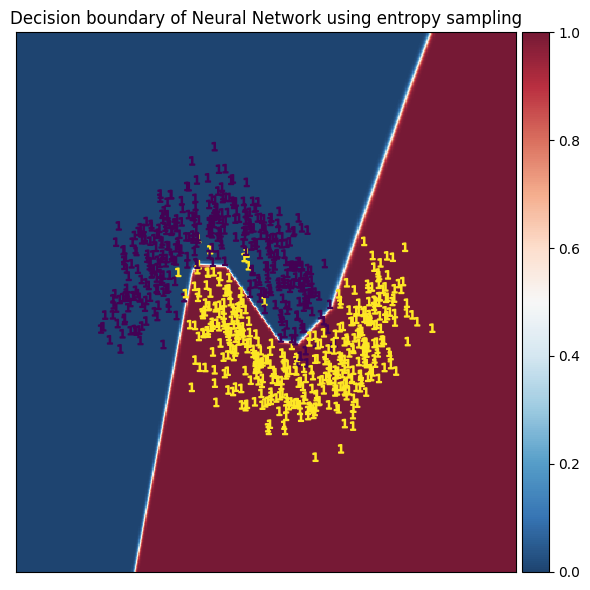

Accuracy on the test set: 98.0% %


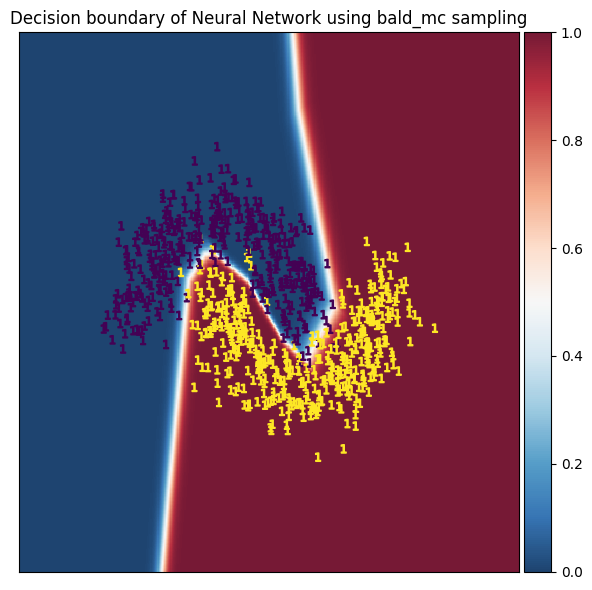

Accuracy on the test set: 97.0% %


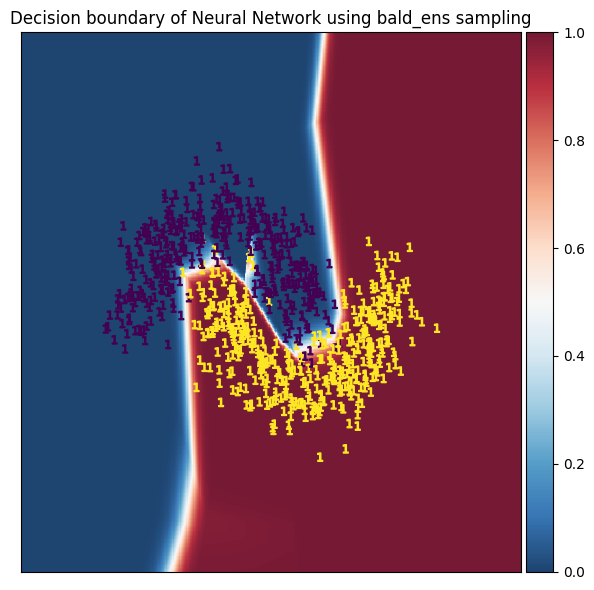

In [ ]:
## Initial data pool
init_pool_size = 10
init_pool_idx = np.random.randint(0,500, size = init_pool_size).tolist()

# model params
batch_size = 256
num_epochs = 30
dropout = 0

# active learning params
num_queries = 100
query_size = 2
lr = 6e-4
n_iter = 3

for s in strat_list:
    plot_decision_boundary_nn(init_pool_idx, acquisition_function=s)

In [13]:
init_pool_size = 10
init_pool_idx = np.random.randint(0,500, size = init_pool_size).tolist()

In [15]:
from src.data.data import ActiveLearningDataset, get_balanced_sample_indices, get_targets
from src.data.data import TwoMoons, MNIST_CUSTOM

# Initialize the dataset.
X, y = make_moons(n_samples = 1000, noise = 0.1, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

twomoons_traindata = TwoMoons(X_train, y_train, return_idx = True)
twomoons_testdata = TwoMoons(X_test, y_test, return_idx = True)


### calculting the grid
xlim_neg = X_train[:,0].min()-1
xlim_pos = X_train[:,0].max()+1
ylim_neg = X_train[:,1].min()-1
ylim_pos = X_train[:,1].max()+1


# Generates the initial balanced pool.
# define how many classes there is in the data and how many samples per class you want.
n_classes = 2
n_init_samples = 20


initial_samples = get_balanced_sample_indices(
    get_targets(twomoons_traindata),
    num_classes=n_classes,
    n_per_digit=n_init_samples / n_classes,
)

init_samples = {'idxs': initial_samples}
with open("init_samples", "wb") as fp:
    pickle.dump(init_samples, fp)

In [16]:
with open("/Users/madsbirch/Documents/bal/init_samples", 'rb') as f:
    init_samples_dict = pickle.load(f)

init_sample_idxs = init_samples_dict['idxs']

random
margin
entropy
bald_mc
bald_ens


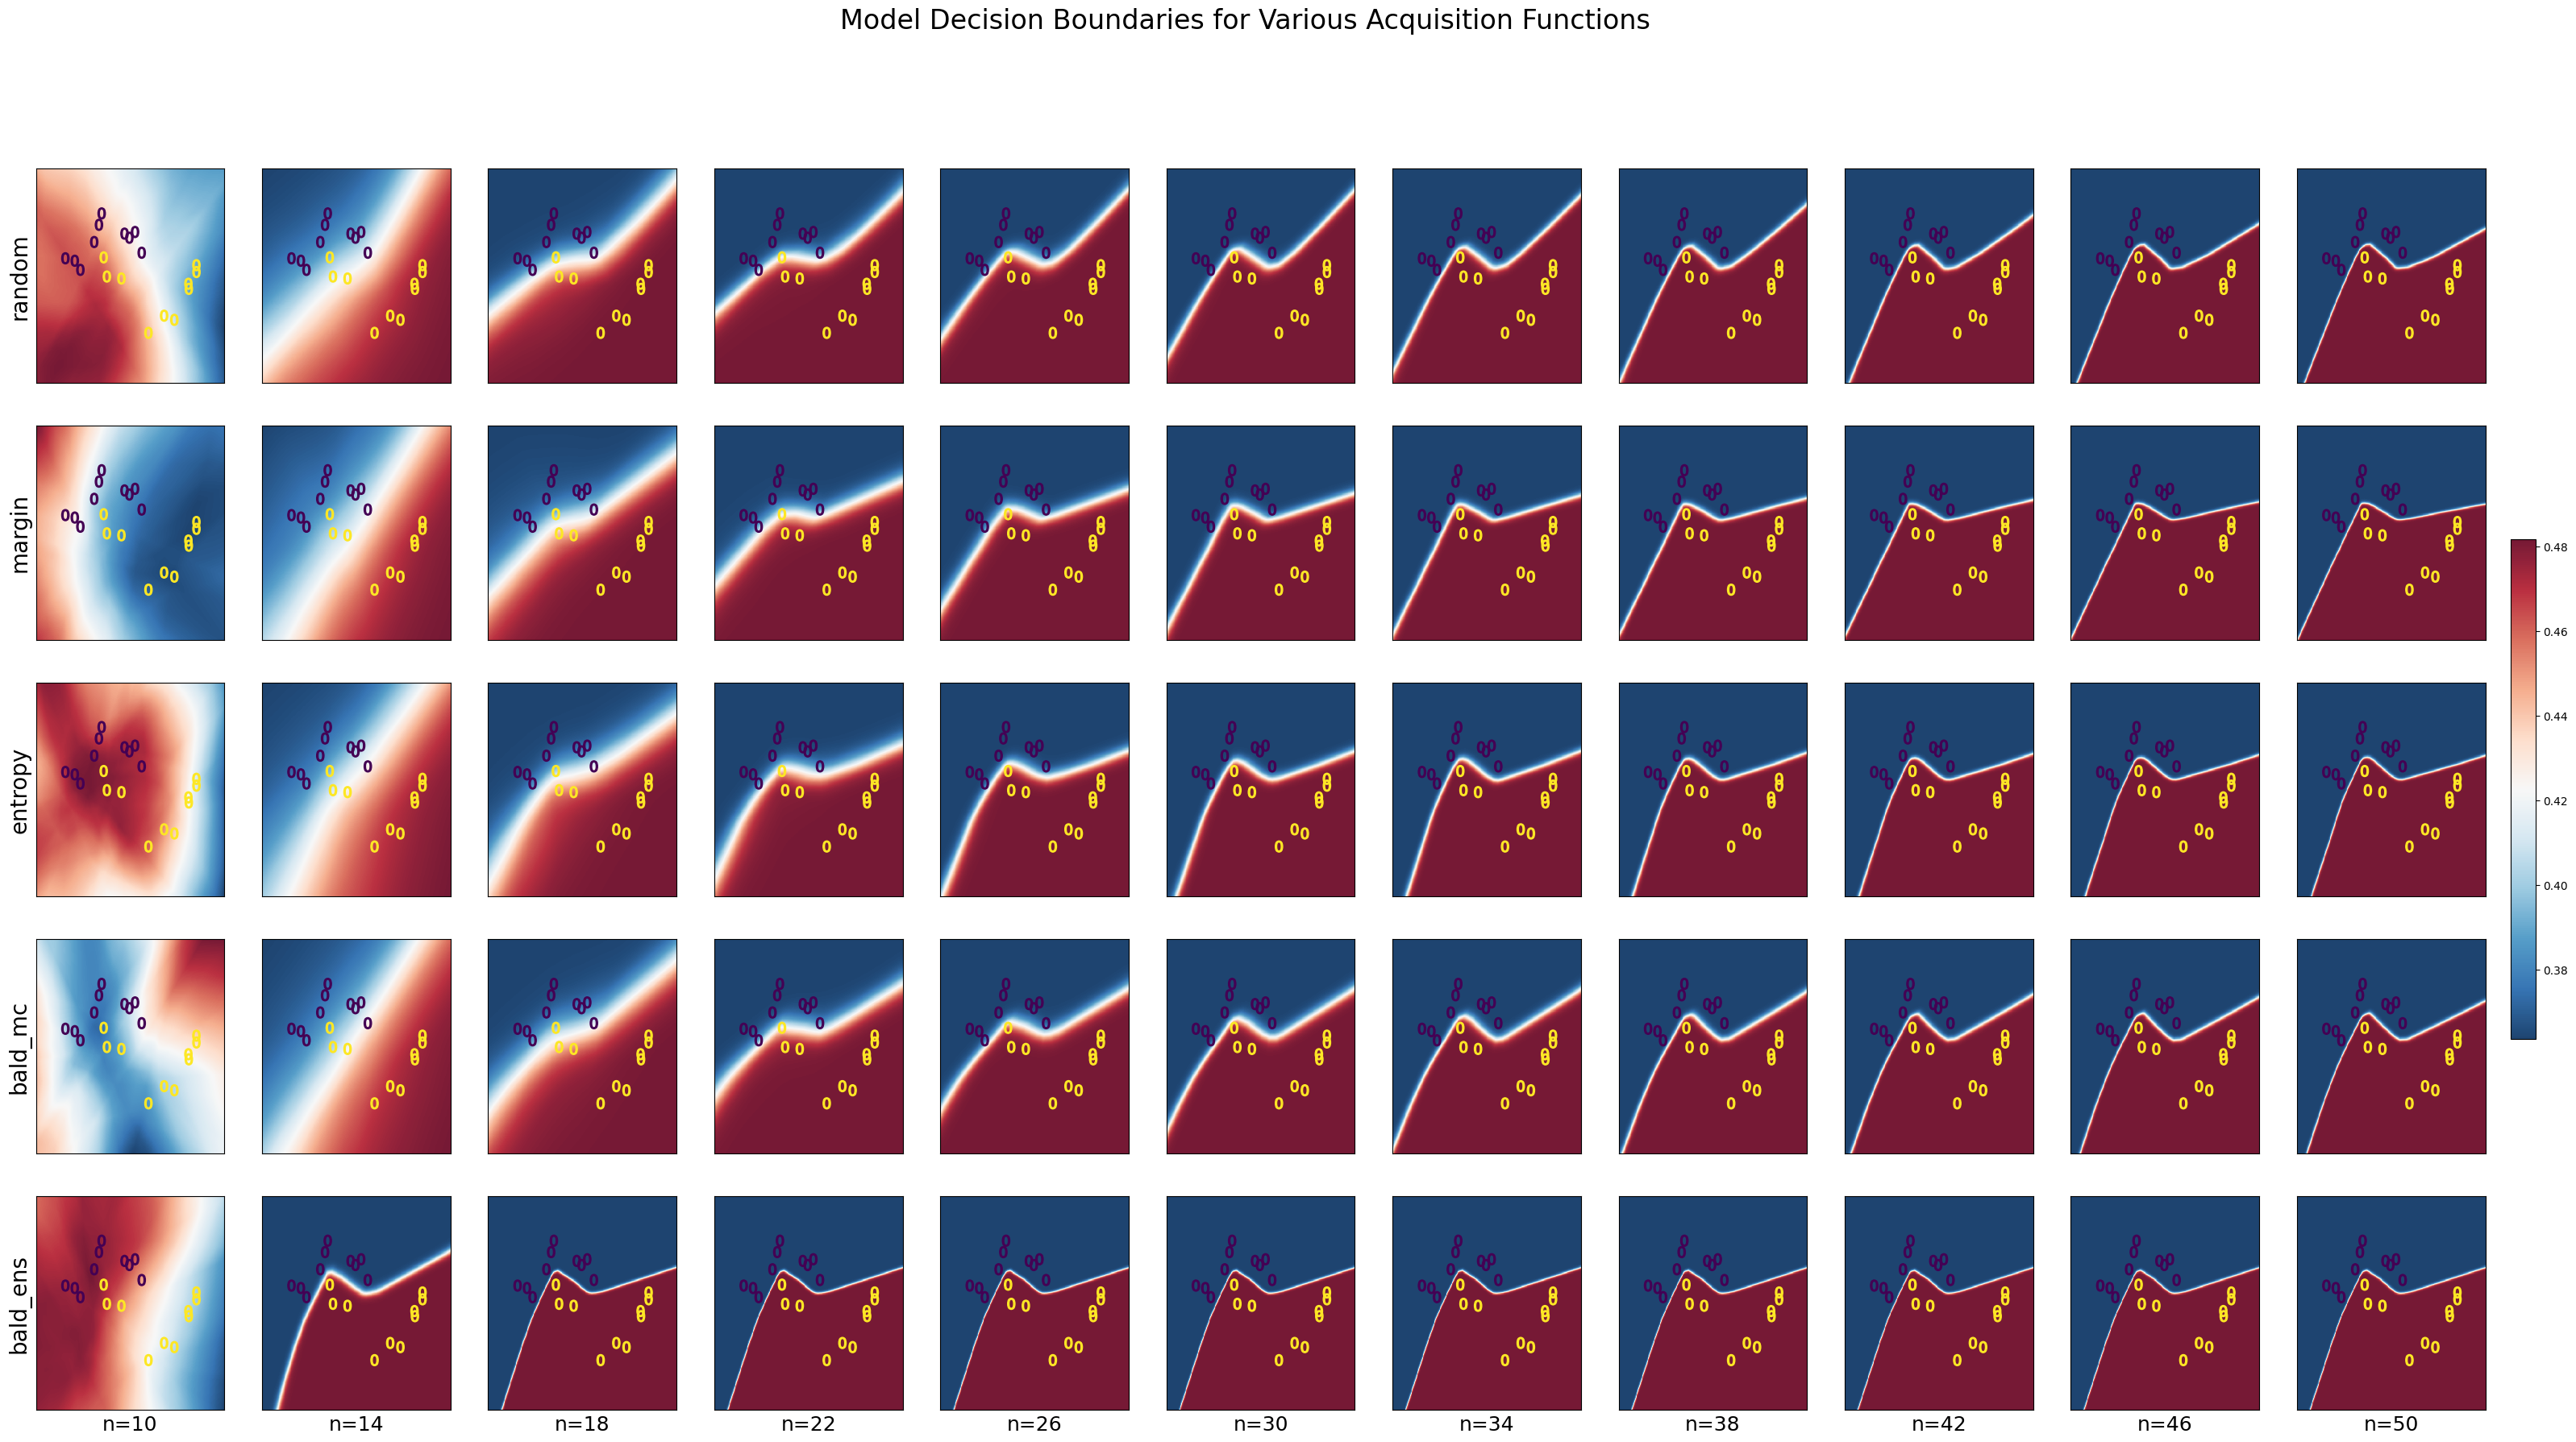

In [22]:
MODEL_PATH = '/Users/madsbirch/Documents/bal/models/'
strat_list = ['random', 'margin', 'entropy', 'bald_mc', 'bald_ens'] # list of sampling strategies

lr = 1e-3
num_queries = 10
query_size = 4
batch_size = 256
num_epochs = 50
num_drop=50
marker_size = 100
n_ens= 5
mesh_alpha = 0.9

# figure init
fig, axs = plt.subplots(nrows=len(strat_list), figsize = (40,20),ncols=num_queries+1,sharex=True, sharey=True)

# Define model and optimizer
twomoons_net = TwoMoons_Model(dropout=dropout)
al_model = AL_Model(twomoons_net, device)

# Initialize the Active Learning Dataset
al_traindata = ActiveLearningDataset(twomoons_traindata)
al_traindata.acquire_samples(init_pool_idx)

al_model.train(al_traindata.labeled_dataset, n_epochs=num_epochs, lr=lr)

# save model state for the common model. Will be reloaded in the loop below. 
state = {
'state_dict': al_model.model.state_dict(),
'optimizer': optimizer.state_dict()
}
torch.save(state, MODEL_PATH+'plot_model.pth')

# Initialize a list to keep track of indices acquired at each step for all strategies
acquired_indices_per_strat = [[] for _ in strat_list]

for i, s in enumerate(strat_list):           
    
    state = torch.load( MODEL_PATH+'plot_model.pth')
    model.load_state_dict(state['state_dict'])
    
    print(s)
    
    # Define model and optimizer
    twomoons_net = TwoMoons_Model(dropout=dropout)
    al_model = AL_Model(twomoons_net, device)
    state = torch.load( MODEL_PATH+'plot_model.pth')
    model.load_state_dict(state['state_dict'])

    # Initialize the Active Learning Dataset
    al_traindata = ActiveLearningDataset(twomoons_traindata)
    al_traindata.acquire_samples(init_sample_idxs)
    
    # Save initial indices for plotting
    acquired_indices_per_strat[i].append(init_sample_idxs)
    
    # Plot initial points with marker 0
    xx, yy, softmax_out = softmax_grid(al_model.model, X_train, y_train)
    mesh = axs[i,0].pcolormesh(xx, yy, softmax_out, cmap=plt.cm.RdBu_r, alpha=mesh_alpha)
    axs[i,0].scatter(X_train[init_sample_idxs,0], X_train[init_sample_idxs,1], c=y_train[init_sample_idxs], marker='$0$', s=marker_size)
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    
    for q in range(1, num_queries + 1):
        # Train model
        al_model.train(al_traindata.labeled_dataset, n_epochs=num_epochs, lr=lr)
        batch_indices = None
        
        if s == "random":
            batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).random()
        
        if s == "margin":
            batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).margin()

        if s == "entropy":
            batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).entropy()
        
        if s == "bald_mc":
            batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_mc(n_drop=num_drop)
        
        if s == "bald_ens":
            batch = Sampling(al_traindata.unlabeled_dataset, al_model, query_size, device).bald_ensemble(traindata = al_traindata.labeled_dataset, n_ens = n_ens, n_epochs = num_epochs, lr = lr)
            
        if batch_indices is not None:
            al_traindata.acquire_samples(batch_indices)
            acquired_indices_per_strat[i].append(batch_indices)

        # Plotting all points up to the current query with appropriate markers
        xx, yy, softmax_out = softmax_grid(al_model.model, X_train, y_train)  # Recalculate for updated model
        axs[i, q].pcolormesh(xx, yy, softmax_out, cmap=plt.cm.RdBu_r, alpha=mesh_alpha)  # Redraw background
        for marker_index, indices in enumerate(acquired_indices_per_strat[i]):
            marker_style = f'${marker_index}$'
            #axs[i, q].scatter(X_train[:,0], X_train[:,1], c = y_train, alpha = 0.1,s=marker_size/2)
            axs[i, q].scatter(X_train[indices, 0], X_train[indices, 1], c=y_train[indices], marker=marker_style, s=marker_size)
            
        
        axs[i, q].set_xticks([])
        axs[i, q].set_yticks([])

fig.colorbar(mesh, ax=axs.ravel().tolist(), fraction=0.01, pad=0.01)
fig.suptitle('Model Decision Boundaries for Various Acquisition Functions', size = 24)

# set ylabels to strategy
for i, strat in enumerate(strat_list):
    axs[i,0].set_ylabel(strat, fontsize=20)

# set xlabels to number of sampled data points.
ns = np.linspace(0, query_size*num_queries, num_queries+1, dtype=int)

for i, n in enumerate(ns):
    axs[len(strat_list)-1,i].set_xlabel(f'n={int(init_pool_size+n)}', fontsize=18)

plt.savefig(FIGURE_PATH+'dec_bound_10.png')
plt.show()

- Recreate the above plot for the GP. Other simple models? A third one to chech why the NN is to overconfident?
- Plot accurare and ECE for each query for each acquisition function.
- Make code more modular. More functions and classes.

In [ ]:
def margin_acquisition():
    pass

def entropy_acquisition():
    pass

def bald_acquisition():
    pass

def query_samples():
    """Query samples from the unlabeled pool using a defined acquisition funtion."""
    pass

def train_model():
    """Trains a model on a given dataset and returns the trained model."""

def AL_train():
    pass

def plot_decision_boundary():
    pass

TODO:
- the acquisition functions scores needs to be investigated. The bald scores are incorrect.
- back to basics med avtive learning data class.

- Print the target distribution for the different sampling strategies (mode collapse):
https://jacobgil.github.io/deeplearning/activelearning

